In [ ]:
# Importing Dependencies
import re
import csv
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Define a helper function to handle biochemical data columns
def preprocess_biochemical_data(column):
    # Convert '<n' to n-0.1 and '>n' to n+0.1
    for i in range(len(column)):
        value = column[i]
        if isinstance(value, str):
            if value.startswith('<'):
                val = float(value[1:])
                column[i] = val - val/2
            elif value.startswith('>'):
                val = float(value[1:])
                column[i] = val + val/2
            else:
                column[i] = float(value)
    return column

## `Datasets exploring, preprocessing and feature extraction process:`

In [ ]:
# Load the training data
clinical_train_path = 'Clinical_Data.train.txt'
genotype_train_path = 'Genotype.train.txt'

clinical_train_df = pd.read_csv(clinical_train_path, sep='\t')
genotype_train_df = pd.read_csv(genotype_train_path, sep='\t')

In [ ]:
# Explore the data
print("Clinical Data:")
print(clinical_train_df.head())

print("\nGenotype Data:")
print(genotype_train_df.head())

Clinical Data:
   PatientId  Gender  Height  Weight Diag  AgeAtDiag  SmokeAtDiag   Leu  \
0          1       2   165.0    59.0   CD       16.0            0   5.5   
1          3       2     NaN     NaN   UC       31.0            0   7.6   
2          4       1   174.0    67.0   CD       31.0            0   NaN   
3          5       2   172.0    60.0   UC       56.0            1  13.6   
4          6       1   182.0    74.0   CD       22.0            1   5.7   

      Hb CRP   ESR  Fer  B12  Fol   Alk   Alb  
0  120.0  20   NaN  NaN  NaN  NaN  61.0   NaN  
1  134.0   5   8.0   53  NaN  NaN  43.0   NaN  
2  103.0  40   NaN  226  299  7.9  69.0  35.0  
3  104.0  23  26.0  NaN  NaN  NaN  87.0  32.0  
4  150.0   2   NaN  NaN  NaN  NaN   NaN  44.0  

Genotype Data:
   PatientId  SNP_0  SNP_1  SNP_2  SNP_3  SNP_4  SNP_5  SNP_6  SNP_7  SNP_8  \
0       1883    0.0   -1.0     -1   -1.0    0.0   -1.0   -1.0    0.0    0.0   
1        530    0.0   -1.0      0    0.0    0.0   -1.0   -1.0    0.0    

In [ ]:
# Check for missing values
print("\nMissing values in Clinical Data:")
print(clinical_train_df.isnull().sum())

print("\nMissing values in Genotype Data:")
print(genotype_train_df.isnull().sum())


Missing values in Clinical Data:
PatientId         0
Gender            0
Height           20
Weight           17
Diag              0
AgeAtDiag         3
SmokeAtDiag       0
Leu              91
Hb               84
CRP             188
ESR            1203
Fer             710
B12             870
Fol            1018
Alk             461
Alb             776
dtype: int64

Missing values in Genotype Data:
PatientId     0
SNP_0         4
SNP_1        27
SNP_2         0
SNP_3         3
             ..
SNP_373      21
SNP_374      11
SNP_375       7
SNP_376      10
SNP_377       4
Length: 379, dtype: int64


In [ ]:
# Merge clinical and genotype data
merged_data = pd.merge(clinical_train_df, genotype_train_df, on='PatientId')

In [ ]:
# Handle missing values and replace it by -1
merged_data = merged_data.fillna(-1)

In [ ]:
# Handle biochemical data columns
biochemical_columns = ['Leu', 'Hb', 'CRP', 'ESR', 'Fer', 'B12', 'Fol', 'Alk', 'Alb']
for column in biochemical_columns:
    merged_data[column] = preprocess_biochemical_data(merged_data[column])

<ipython-input-213-00ea1d9c3080>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[i] = float(value)
<ipython-input-213-00ea1d9c3080>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[i] = val - val/2
<ipython-input-213-00ea1d9c3080>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[i] = val + val/2


In [ ]:
# Check everything is correct
merged_data.head()

,PatientId,Gender,Height,Weight,Diag,AgeAtDiag,SmokeAtDiag,Leu,Hb,CRP,...,SNP_368,SNP_369,SNP_370,SNP_371,SNP_372,SNP_373,SNP_374,SNP_375,SNP_376,SNP_377
0,1,2,165.0,59.0,CD,16.0,0,5.5,120.0,20.0,...,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,3,2,-1.0,-1.0,UC,31.0,0,7.6,134.0,5.0,...,0.0,1.0,0.0,1.0,-1.0,-1.0,-1.0,0.0,1.0,1.0
2,4,1,174.0,67.0,CD,31.0,0,-1.0,103.0,40.0,...,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0
3,5,2,172.0,60.0,UC,56.0,1,13.6,104.0,23.0,...,-1.0,-1.0,1.0,0.0,0.0,0.0,-1.0,0.0,-1.0,-1.0
4,6,1,182.0,74.0,CD,22.0,1,5.7,150.0,2.0,...,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0


In [ ]:
# Select relevant features
selected_features = ['Gender', 'Height', 'Weight', 'AgeAtDiag', 'SmokeAtDiag', 'Leu', 'Hb', 'CRP', 'ESR', 'Fer', 'B12', 'Fol', 'Alk', 'Alb']
selected_features += [f'SNP_{i}' for i in range(378)]  # Add SNP features dynamically

**Gender:**
> Women are more likely to develop Crohn's disease than men, but more men develop ulcerative colitis than women. Even though the average age of developing IBD is between 15 and 35, more men are diagnosed with ulcerative colitis in their 50s and 60s than women of the same age.

**SmokeAtDiag:**
> We know that smoking is one of the environmental risk factors linked to IBD, and that it increases the risk of developing Crohn's and can significantly worsen IBD symptoms.

**Height and Weight (BMI):**
> The principal findings of our meta-analysis of 10 cohort studies showed a direct association between BMI (both lower BMI and higher BMI) and risk of IBD, particularly CD.

**Age:**
> So aging patients with IBD are at even greater risk for many of the classic inflammation-linked health outcomes, including cardiovascular disease, cancer, obesity, skin issues, arthritis, and skeletal muscle loss.




In [ ]:
# Prepare the data for training
X = merged_data[selected_features]
y = merged_data['Diag'].map({'CD': 0, 'UC': 1})  # Map diagnosis labels to binary values (0 for CD, 1 for UC)

In [ ]:
# Load the testing data
clinical_test_path = 'Clinical_Data.test.txt'
genotype_test_path = 'Genotype.test.txt'

clinical_test_df = pd.read_csv(clinical_test_path, sep='\t')
genotype_test_df = pd.read_csv(genotype_test_path, sep='\t')

In [ ]:
# Explore the data
print("Clinical Test Data:")
print(clinical_test_df.head())

print("\nGenotype Test Data:")
print(genotype_test_df.head())

Clinical Test Data:
   PatientId  Gender  Height  Weight  AgeAtDiag  SmokeAtDiag  Leu_signe   Leu  \
0          2       2     163      52         16            1        NaN   NaN   
1          8       1     170      77         59            1        NaN   6.9   
2         13       2     158      49         21            0        NaN  13.5   
3         24       1     180      72         10            0        NaN   9.3   
4         55       2     164      58         34            1        NaN   4.5   

   Hb_signe     Hb  ... Fer_signe    Fer  B12_signe    B12  Fol_signe   Fol  \
0       NaN    NaN  ...       NaN    NaN        NaN    NaN        NaN   NaN   
1       NaN  169.0  ...       NaN  524.0        NaN  128.0        NaN   4.4   
2       NaN  130.0  ...       NaN    NaN        NaN    NaN        NaN   NaN   
3       NaN  150.0  ...       NaN   43.0        NaN  289.0        NaN  12.6   
4       NaN  141.0  ...       NaN    NaN        NaN    NaN        NaN   NaN   

   Alk_signe   Alk

In [ ]:
# Check for missing values
print("\nMissing values in Clinical Data:")
print(clinical_test_df.isnull().sum())

print("\nMissing values in Genotype Data:")
print(genotype_test_df.isnull().sum())


Missing values in Clinical Data:
PatientId       0
Gender          0
Height          0
Weight          0
AgeAtDiag       0
SmokeAtDiag     0
Leu_signe      40
Leu             2
Hb_signe       40
Hb              2
CRP_signe      32
CRP             4
ESR_signe      40
ESR            21
Fer_signe      40
Fer            12
B12_signe      40
B12            16
Fol_signe      39
Fol            18
Alk_signe      40
Alk             9
Alb_signe      40
Alb            18
dtype: int64

Missing values in Genotype Data:
PatientId    0
SNP_0        0
SNP_1        0
SNP_2        0
SNP_3        0
            ..
SNP_373      0
SNP_374      0
SNP_375      0
SNP_376      0
SNP_377      0
Length: 379, dtype: int64


In [ ]:
# Merge clinical and genotype data
merged_test_data = pd.merge(clinical_test_df, genotype_test_df, on='PatientId')

In [ ]:
# Handle missing values and replace it by -1
merged_test_data = merged_test_data.fillna(-1)

In [ ]:
# Handle biochemical data columns
biochemical_test_columns = ['Leu', 'Hb', 'CRP', 'ESR', 'Fer', 'B12', 'Fol', 'Alk', 'Alb']
for column in biochemical_test_columns:
    merged_test_data[column] = preprocess_biochemical_data(merged_test_data[column])

<ipython-input-213-00ea1d9c3080>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[i] = float(value)
<ipython-input-213-00ea1d9c3080>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[i] = val - val/2


In [ ]:
# Check everything is correct
merged_test_data

,PatientId,Gender,Height,Weight,AgeAtDiag,SmokeAtDiag,Leu_signe,Leu,Hb_signe,Hb,...,SNP_368,SNP_369,SNP_370,SNP_371,SNP_372,SNP_373,SNP_374,SNP_375,SNP_376,SNP_377
0,2,2,163,52,16,1,-1.0,-1.00,-1.0,-1.0,...,-1,-1,-1,1,-1,-1,0,0,0,-1
1,8,1,170,77,59,1,-1.0,6.90,-1.0,169.0,...,0,1,0,1,-1,-1,0,1,-1,0
2,13,2,158,49,21,0,-1.0,13.50,-1.0,130.0,...,-1,0,-1,-1,0,0,-1,-1,-1,0
3,24,1,180,72,10,0,-1.0,9.30,-1.0,150.0,...,1,-1,0,1,-1,-1,1,0,-1,0
4,55,2,164,58,34,1,-1.0,4.50,-1.0,141.0,...,-1,-1,0,1,-1,-1,-1,-1,0,-1
5,62,1,182,80,43,1,-1.0,4.10,-1.0,126.0,...,1,0,-1,1,-1,-1,-1,0,-1,0
6,95,1,168,54,19,1,-1.0,10.90,-1.0,127.0,...,-1,1,-1,0,-1,-1,1,-1,0,0
7,104,2,150,44,41,1,-1.0,8.50,-1.0,113.0,...,-1,-1,-1,1,-1,-1,0,0,0,0
8,153,1,175,95,34,0,-1.0,10.70,-1.0,141.0,...,-1,-1,0,1,-1,-1,1,0,0,0
9,159,2,159,55,54,1,-1.0,15.00,-1.0,131.0,...,-1,-1,1,0,-1,-1,1,-1,1,0


In [ ]:
# Select relevant features
selected_features = ['Gender', 'Height', 'Weight', 'AgeAtDiag', 'SmokeAtDiag', 'Leu', 'Hb', 'CRP', 'ESR', 'Fer', 'B12', 'Fol', 'Alk', 'Alb']
selected_test_features += [f'SNP_{i}' for i in range(378)]  # Add SNP features dynamically

## `Training and Testing: Logistic Regression Model`

In [ ]:
# Split the data into training and validation sets
X_log_train, X_log_val, y_log_train, y_log_val = train_test_split(X, y, test_size=0.001, random_state=1000000000)

In [ ]:
# Train a logistic regression model
log_model = LogisticRegression()
log_model.fit(X_log_train, y_log_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
# Make predictions on the validation set
y_log_pred = log_model.predict(X_log_val)

In [ ]:
# Evaluate the model's performance
accuracy = accuracy_score(y_log_val, y_log_pred)
print("Validation Accuracy:", accuracy)

Validation Accuracy: 1.0


In [ ]:
X_test = merged_test_data[selected_test_features]
y_pred_test = log_model.predict(X_test)

In [ ]:
# Store the predicted diagnosis values for the 40 patients
merged_test_data['Predicted_Diag'] = y_pred_test

In [ ]:
# Create a DataFrame with 'PatientId' and 'Diag' columns
result = pd.DataFrame({'PatientId': merged_test_data['PatientId'], 'Diag': y_pred_test})

In [ ]:
result.to_csv('predicted_diagnoses.csv', index=False)

In [ ]:
result

,PatientId,Diag
0,2,1
1,8,0
2,13,0
3,24,1
4,55,0
5,62,0
6,95,0
7,104,0
8,153,0
9,159,0


## `Training and Testing: Random Forest Model`

In [ ]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.001, random_state=1000000000)

In [ ]:
# Train a Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
# Make predictions on the validation set
y_pred = rf_model.predict(X_val)

In [ ]:
# Evaluate the model's performance
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)

Validation Accuracy: 0.5


In [ ]:
# Select relevant features
X_test = merged_test_data[selected_test_features]
y_pred_test = rf_model.predict(X_test)

In [ ]:
# Store the predicted diagnosis values for the 40 patients
merged_test_data['Predicted_Diag'] = y_pred_test

In [ ]:
# Create a DataFrame with 'PatientId' and 'Diag' columns
result = pd.DataFrame({'PatientId': merged_test_data['PatientId'], 'Diag': y_pred_test})
result.to_csv('predicted_diagnoses.csv', index=False)
result.head(20)

,PatientId,Diag
0,2,0
1,8,0
2,13,0
3,24,1
4,55,0
5,62,0
6,95,0
7,104,0
8,153,0
9,159,0


## `Training and Testing: Gradient Boosting -> Favourite 👑`

In [ ]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.0001, random_state=1000000000)

In [ ]:
# Perform feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [ ]:
# Configure the hyperparameters for Gradient Boosting
params = {
  'n_estimators': 1000, # Increase the number of boosting stages
  'learning_rate': 0.01, # Lower the learning rate
  'max_depth': 5, # Increase the maximum depth of each tree
  'subsample': 0.9, # Keep the subsample ratio as 0.9
  'min_samples_split': 5, # Increase the minimum number of samples required to split
  'min_samples_leaf': 2, # Increase the minimum number of samples required to be at a leaf node
  'random_state': 1000000000 # Keep the random state as 42 for reproducibility
}

In [ ]:
# Train a Gradient Boosting model
gb_model = GradientBoostingClassifier(**params)
gb_model.fit(X_train_scaled, y_train)

GradientBoostingClassifier(learning_rate=0.01, max_depth=5, min_samples_leaf=2,
                           min_samples_split=5, n_estimators=1000,
                           random_state=1000000000, subsample=0.9)

In [ ]:
# Make predictions on the validation set
y_pred = gb_model.predict(X_val_scaled)

In [ ]:
# Evaluate the model's performance
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)

Validation Accuracy: 1.0


In [ ]:
# Select relevant features
X_test_scaled = scaler.transform(X_test)
y_pred_test = gb_model.predict(X_test_scaled)

In [ ]:
# Store the predicted diagnosis values for the 40 patients
merged_test_data['Predicted_Diag'] = y_pred_test

In [ ]:
# Create a DataFrame with 'PatientId' and 'Diag' columns
result = pd.DataFrame({'PatientId': merged_test_data['PatientId'], 'Diag': y_pred_test})
result.to_csv('predicted_diagnoses.csv', index=False)
result

,PatientId,Diag
0,2,0
1,8,0
2,13,0
3,24,1
4,55,0
5,62,0
6,95,0
7,104,0
8,153,0
9,159,0


## `Training and Testing: K-Nearest Neighbors`

In [ ]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=1000000000)

In [ ]:
# Train a K-Nearest Neighbors model
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
# Make predictions on the validation set
y_pred = knn_model.predict(X_val)

In [ ]:
# Evaluate the model's performance
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)

Validation Accuracy: 0.5296803652968036


In [ ]:
# Select relevant features
X_test = merged_test_data[selected_test_features]
y_pred_test = gb_model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


In [ ]:
# Store the predicted diagnosis values for the 40 patients
merged_test_data['Predicted_Diag'] = y_pred_test

In [ ]:
# Create a DataFrame with 'PatientId' and 'Diag' columns
result = pd.DataFrame({'PatientId': merged_test_data['PatientId'], 'Diag': y_pred_test})
result.to_csv('predicted_diagnoses.csv', index=False)
result

,PatientId,Diag
0,2,1
1,8,0
2,13,1
3,24,1
4,55,1
5,62,0
6,95,1
7,104,1
8,153,1
9,159,1


## `Training and Testing: Naive Bayes`

In [ ]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.001, random_state=1000000000)

In [ ]:
# Train a K-Nearest Neighbors model
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

GaussianNB()

In [ ]:
# Make predictions on the validation set
y_pred = nb_model.predict(X_val)

In [ ]:
# Evaluate the model's performance
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)

Validation Accuracy: 1.0


In [ ]:
# Select relevant features
X_test = merged_test_data[selected_test_features]
y_pred_test = gb_model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


In [ ]:
# Store the predicted diagnosis values for the 40 patients
merged_test_data['Predicted_Diag'] = y_pred_test

In [ ]:
# Create a DataFrame with 'PatientId' and 'Diag' columns
result = pd.DataFrame({'PatientId': merged_test_data['PatientId'], 'Diag': y_pred_test})
result.to_csv('predicted_diagnoses.csv', index=False)
result.head(20)

,PatientId,Diag
0,2,1
1,8,0
2,13,1
3,24,1
4,55,1
5,62,0
6,95,1
7,104,1
8,153,1
9,159,1


## `Resultant Data Visualization`

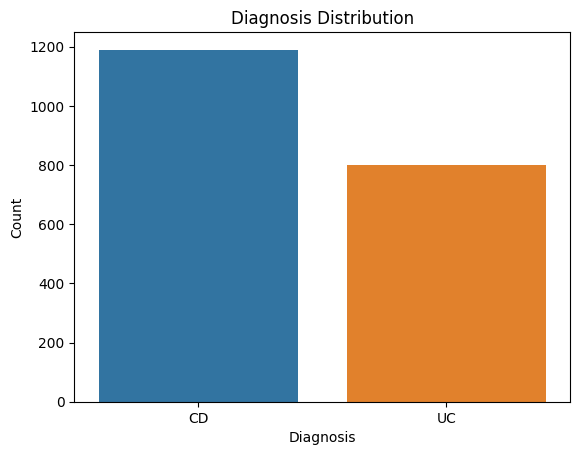

In [ ]:
# Visualize the diagnosis distribution
sns.countplot(data=merged_data, x='Diag')
plt.title('Diagnosis Distribution')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()

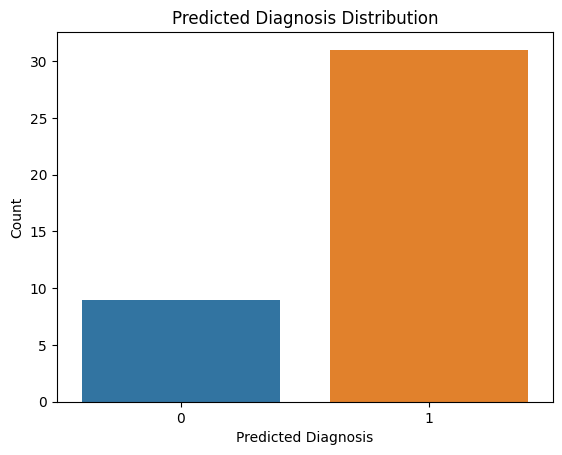

In [ ]:
# Visualize the predicted diagnosis distribution
sns.countplot(data=result, x='Diag')
plt.title('Predicted Diagnosis Distribution')
plt.xlabel('Predicted Diagnosis')
plt.ylabel('Count')
plt.show()